# Section 1: Import Packages

In [41]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping,ModelCheckpoint
import random

# Section 2: Data Preprocessing

### Tumor Classification

In [19]:
path='./Data'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,.DS_Store
1,meningioma_tumor
2,glioma_tumor
3,pituitary_tumor
4,normal


### Data Splitting (70% for training, 20% for validation)


In [20]:
data_directory = "./Original_Data"

# Create a TensorFlow dataset
batch_size = 32
image_size = (224,224) # For VGG-16
validation_split = 0.2

# Create a training set
vgg16_train = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=validation_split,  
    subset="training",
    seed=123,  
    image_size=image_size,
    batch_size=batch_size,
)

# Create a validation and test set
vgg16_validation = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,  
    subset="validation",
    seed=123, 
    image_size=image_size,
    batch_size=batch_size,
)

Found 3096 files belonging to 4 classes.
Using 2477 files for training.
Found 3096 files belonging to 4 classes.
Using 619 files for validation.


In [21]:
batch_size = 32
image_size = (256, 256)  
validation_split = 0.2

# Create a training set
train = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=validation_split,  
    subset="training",
    seed=123,  
    image_size=image_size,
    batch_size=batch_size,
)

# Create a validation and test set
validation = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,  
    subset="validation",
    seed=123,  
    image_size=image_size,
    batch_size=batch_size,
)

Found 3096 files belonging to 4 classes.
Using 2477 files for training.
Found 3096 files belonging to 4 classes.
Using 619 files for validation.


### Class names

In [22]:
class_names = train.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

### Image Examples

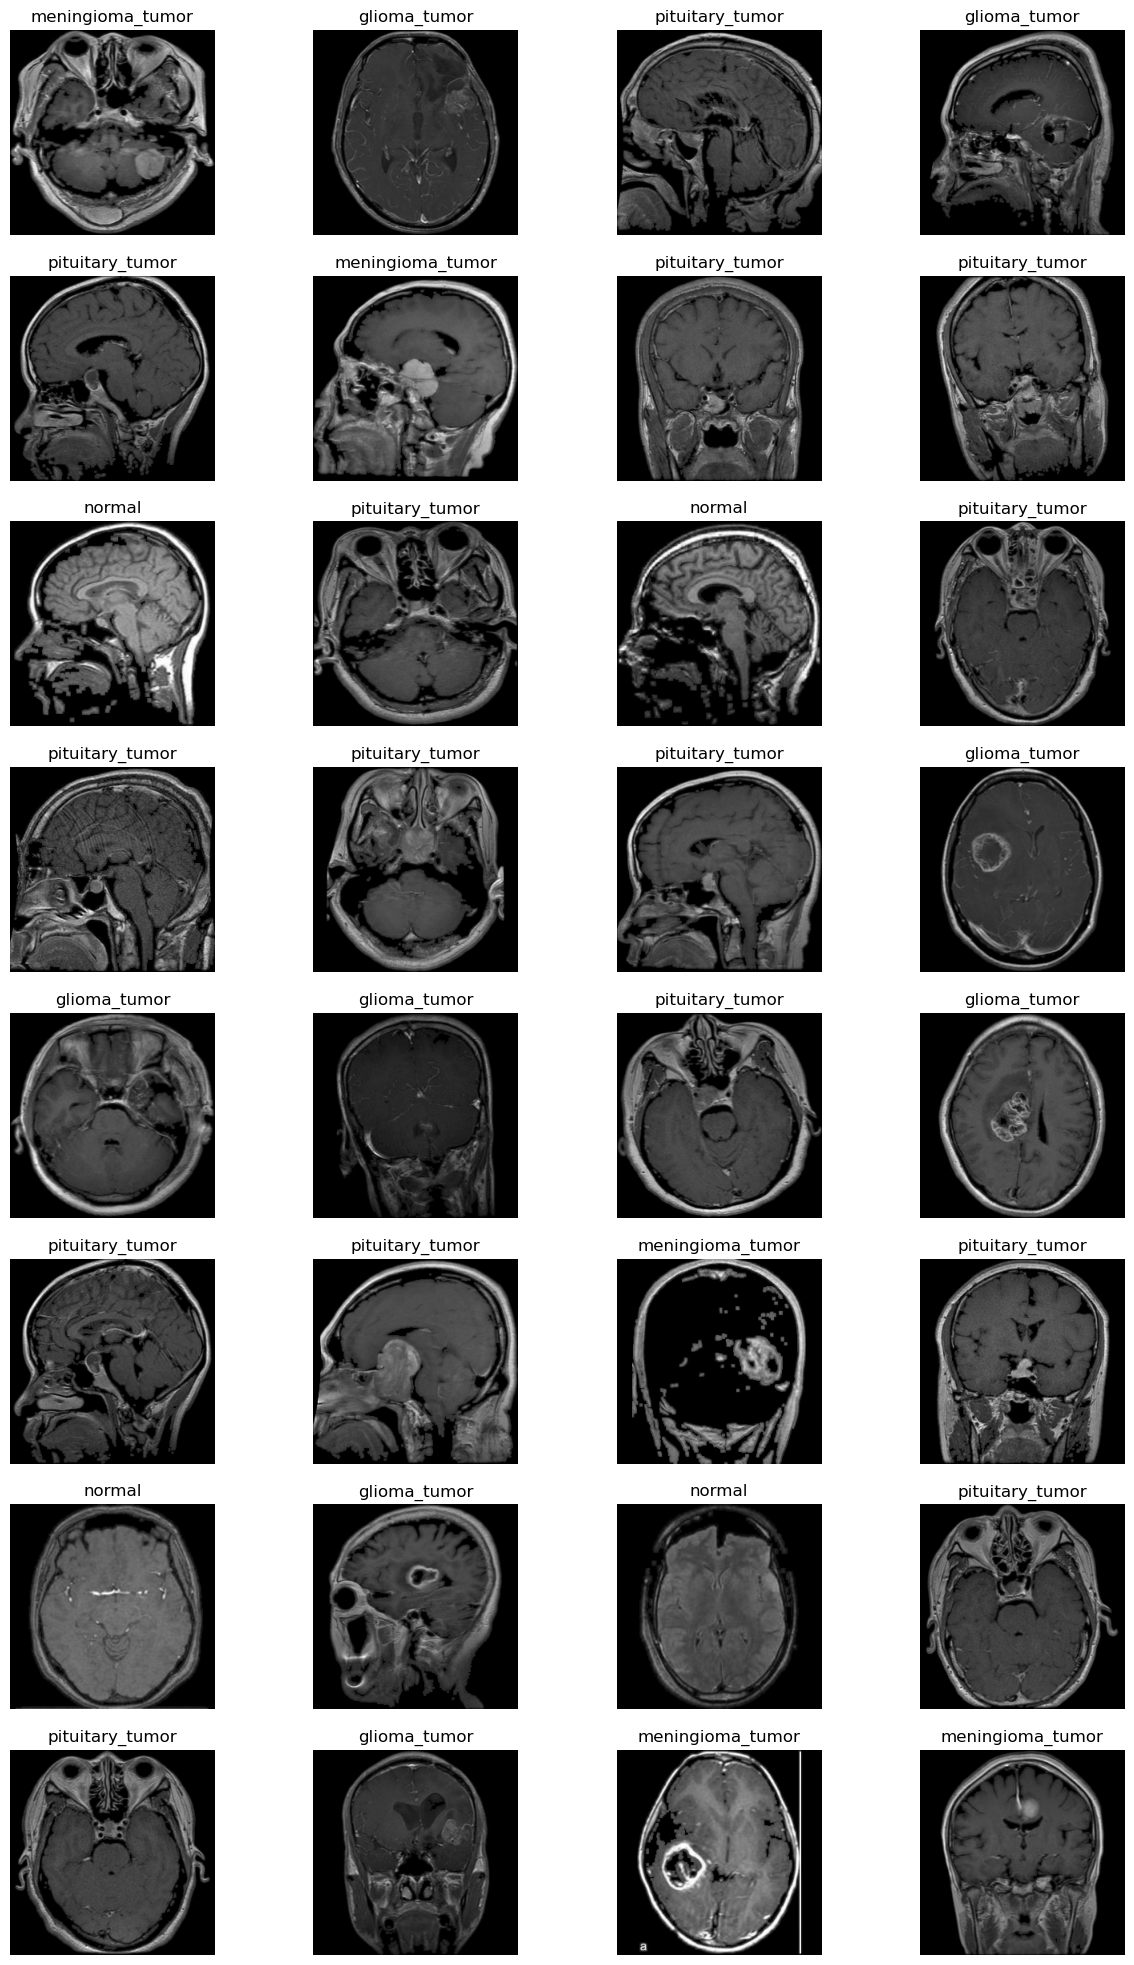

In [23]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1): # iterate over the 1st batch in train set
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

# Section 3: Building CNN

### Early Stopping


In [24]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)

## Building Model From Scratch

### Initializing the CNN

In [25]:
cnn = tf.keras.models.Sequential()

### Convolution

In [26]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[256,256,3]))

### Pooling

In [27]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

### Adding a second convolutional layer

In [28]:
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

### Adding a third convolutional layer

In [29]:
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

### Flattening

In [30]:
cnn.add(tf.keras.layers.Flatten())

### Fully Connection

In [31]:
cnn.add(tf.keras.layers.Dense(units=32,activation='relu'))
cnn.add(tf.keras.layers.Dense(units=16,activation='relu'))

### Output Layer

In [32]:
cnn.add(tf.keras.layers.Dense(units=4,activation='softmax'))

### Model Summary

In [33]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

### Model Visualization

In [34]:
tf.keras.utils.plot_model(cnn, to_file='cnn.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Section 4: Training the CNN

### Compiling the CNN

In [35]:
cnn.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics = ['accuracy']
)

### Training the CNN on Training set

In [36]:
# train is a Tensorflow dataset that contains both the input data and labels, so there's no need to split it into x and y separately
cnn.fit(train, validation_data = validation, epochs = 50, callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50
78/78 [==============================] - 43s 552ms/step - loss: 7.5217 - accuracy: 0.4106 - val_loss: 1.0359 - val_accuracy: 0.5315
Epoch 2/50


/Users/chuongtran/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 41s 530ms/step - loss: 0.7845 - accuracy: 0.6714 - val_loss: 0.9442 - val_accuracy: 0.6527
Epoch 3/50
78/78 [==============================] - 43s 545ms/step - loss: 0.4980 - accuracy: 0.8010 - val_loss: 1.0916 - val_accuracy: 0.7124
Epoch 4/50
78/78 [==============================] - 41s 530ms/step - loss: 0.3280 - accuracy: 0.8870 - val_loss: 1.1448 - val_accuracy: 0.7399
Epoch 5/50
78/78 [==============================] - 41s 527ms/step - loss: 0.2451 - accuracy: 0.9136 - val_loss: 1.1674 - val_accuracy: 0.7383
Epoch 6/50
78/78 [==============================] - 41s 529ms/step - loss: 0.1627 - accuracy: 0.9459 - val_loss: 1.0508 - val_accuracy: 0.7819
Epoch 7/50
78/78 [==============================] - 43s 551ms/step - loss: 0.0975 - accuracy: 0.9669 - val_loss: 1.1100 - val_accuracy: 0.7819


## VGG 16 Model

### Initializing the VGG 16 Model

In [37]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
vgg16_model=tf.keras.models.Sequential()
vgg16_model.add(base_model)
vgg16_model.add(tf.keras.layers.Flatten()) 
vgg16_model.add(tf.keras.layers.Dropout(.5))
vgg16_model.add(tf.keras.layers.Dense(4,activation=tf.nn.softmax))
vgg16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Visualization

In [38]:
tf.keras.utils.plot_model(vgg16_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Training

In [39]:
vgg16_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist=vgg16_model.fit_generator(vgg16_train,epochs=20,validation_data=vgg16_validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20


/var/folders/10/0cfn45p55c58pn13h6rr4rvw0000gn/T/ipykernel_12413/2758426026.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=vgg16_model.fit_generator(vgg16_train,epochs=20,validation_data=vgg16_validation,callbacks=[checkpoint_cb,early_stopping_cb])


78/78 [==============================] - 263s 3s/step - loss: 6.6086 - accuracy: 0.6976 - val_loss: 3.0577 - val_accuracy: 0.8384
Epoch 2/20
78/78 [==============================] - 252s 3s/step - loss: 2.6477 - accuracy: 0.8676 - val_loss: 3.0502 - val_accuracy: 0.8756
Epoch 3/20
78/78 [==============================] - 243s 3s/step - loss: 1.8699 - accuracy: 0.9031 - val_loss: 4.0998 - val_accuracy: 0.8643
Epoch 4/20
78/78 [==============================] - 241s 3s/step - loss: 1.4376 - accuracy: 0.9221 - val_loss: 2.9048 - val_accuracy: 0.9015
Epoch 5/20
78/78 [==============================] - 253s 3s/step - loss: 1.2716 - accuracy: 0.9362 - val_loss: 3.5265 - val_accuracy: 0.8934
Epoch 6/20
78/78 [==============================] - 244s 3s/step - loss: 0.7888 - accuracy: 0.9524 - val_loss: 3.9639 - val_accuracy: 0.8966
Epoch 7/20
78/78 [==============================] - 239s 3s/step - loss: 0.9341 - accuracy: 0.9548 - val_loss: 3.3109 - val_accuracy: 0.9257
Epoch 8/20
78/78 [======

# Section 5: Evaluating the CNN

## Self-built Model

### Making a single prediction

Result: pituitary_tumor
1/1 [==============================] - 0s 74ms/step
3
Result:  pituitary_tumor


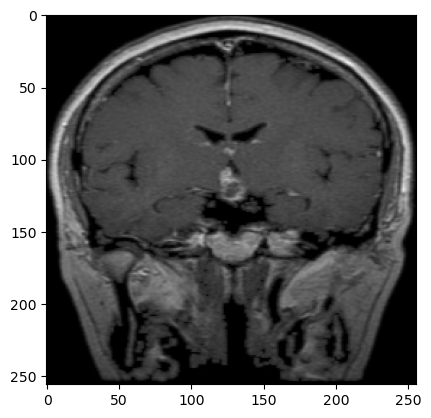

In [42]:
image_type = "pituitary_tumor" 

single_prediction_pituitary_path = os.path.join("./Test", image_type)

all_files = os.listdir(single_prediction_pituitary_path)

image_files = [f for f in all_files if f.lower().endswith(( '.jpg'))]

# Check if there are any image files in the folder
if len(image_files) == 0:
    print("No image files found in the folder.")
else:
    # Choose a random image file
    random_image = random.choice(image_files)
    print("Result:", image_type)
    

    random_image_path = os.path.join(single_prediction_pituitary_path, random_image)


test_img = image.load_img(random_image_path, target_size=(256,256))
plt.imshow(test_img)
test_img = image.img_to_array(test_img)

# We train the CNN based on batch so we need to convert test_img into batch (adding 1 more dimension)
test_img = np.expand_dims(test_img, axis=0)

model_predict = tf.nn.softmax(cnn.predict(test_img))
class_index = np.argmax(model_predict.numpy())

print(class_index)

print("Result: ", class_names[class_index])

### Evaluation

In [43]:
score, acc = cnn.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

20/20 [==============================] - 3s 140ms/step - loss: 0.9442 - accuracy: 0.6527
Test Loss = 0.9441735148429871
Test Accuracy = 0.6526656150817871


### Training History

In [44]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,6.608622,0.697618,3.057728,0.838449
1,2.647671,0.867582,3.050216,0.875606
2,1.869924,0.903109,4.099842,0.864297
3,1.437617,0.922083,2.904834,0.901454
4,1.271590,0.936213,3.526455,0.893376
5,0.788810,0.952362,3.963894,0.896607
6,0.934061,0.954784,3.310875,0.925687
7,0.652092,0.964069,3.845070,0.912763
8,0.637187,0.963666,4.224883,0.901454


### Plot

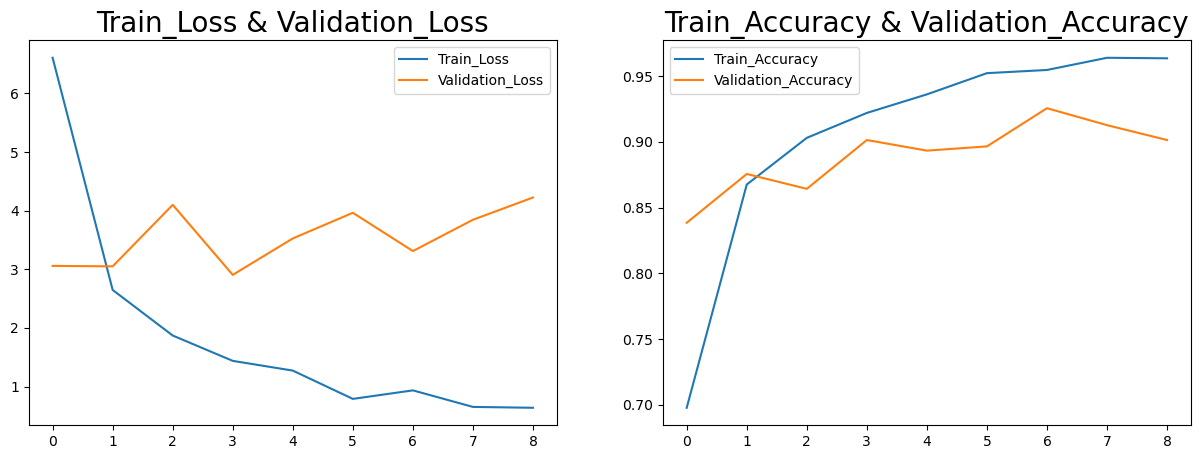

In [45]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## VGG 16 Model

### Evaluation

In [ ]:
score, acc = vgg16_model.evaluate(vgg16_validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

 8/20 [===========>..................] - ETA: 30s - loss: 3.2830 - accuracy: 0.8789

### Training History

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

### Plot

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()